Libraries and Packages 

In [1]:
#All libraries and packages are here
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import torch
import torch.nn.functional as F
from torch.utils.data import DataLoader
from datetime import timedelta
from datasets import Dataset
from transformers import AutoTokenizer, AutoModelForSequenceClassification
from transformers import Trainer, TrainingArguments
from transformers import DataCollatorWithPadding
from transformers import Trainer
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn.utils.class_weight import compute_class_weight
model_name = "ProsusAI/finbert"
tokenizer = AutoTokenizer.from_pretrained(model_name)
model = AutoModelForSequenceClassification.from_pretrained(model_name, num_labels=3)




In [ ]:
#This section is to select mps for apple silicon
print(torch.__version__)
print("GPU:", torch.backends.mps.is_available())
x = torch.rand(3, 3).to("mps")  # send tensor to Apple GPU
print(x)


2.6.0
GPU: True
tensor([[0.7246, 0.0312, 0.3205],
        [0.5531, 0.5861, 0.0923],
        [0.3632, 0.1984, 0.9339]], device='mps:0')


Load price data

In [ ]:
# Load the data
df = pd.read_csv("archive/prices_historical_corn.csv")

# Rename and parse dates
df = df.rename(columns={"date": "Date", "value": "Price"})

# Ensure Date is datetime
df["Date"] = pd.to_datetime(df["Date"])
df = df.sort_values("Date")

# Create a full daily date range for getting days there is no price
full_range = pd.date_range(start=df["Date"].min(), end=df["Date"].max())

# Set Date as index and reindex
df = df.set_index("Date").reindex(full_range)

# Rename index back to 'Date'
df.index.name = "Date"

# Forward-fill missing values for days such as holidays
df = df.ffill().reset_index()
corn_df = df.sort_values("Date")
# Save to CSV (optional)
corn_df.to_csv("corn_prices_processed.csv", index=False)

Preprocess Price data to calculate 5 and 20 day moving averages

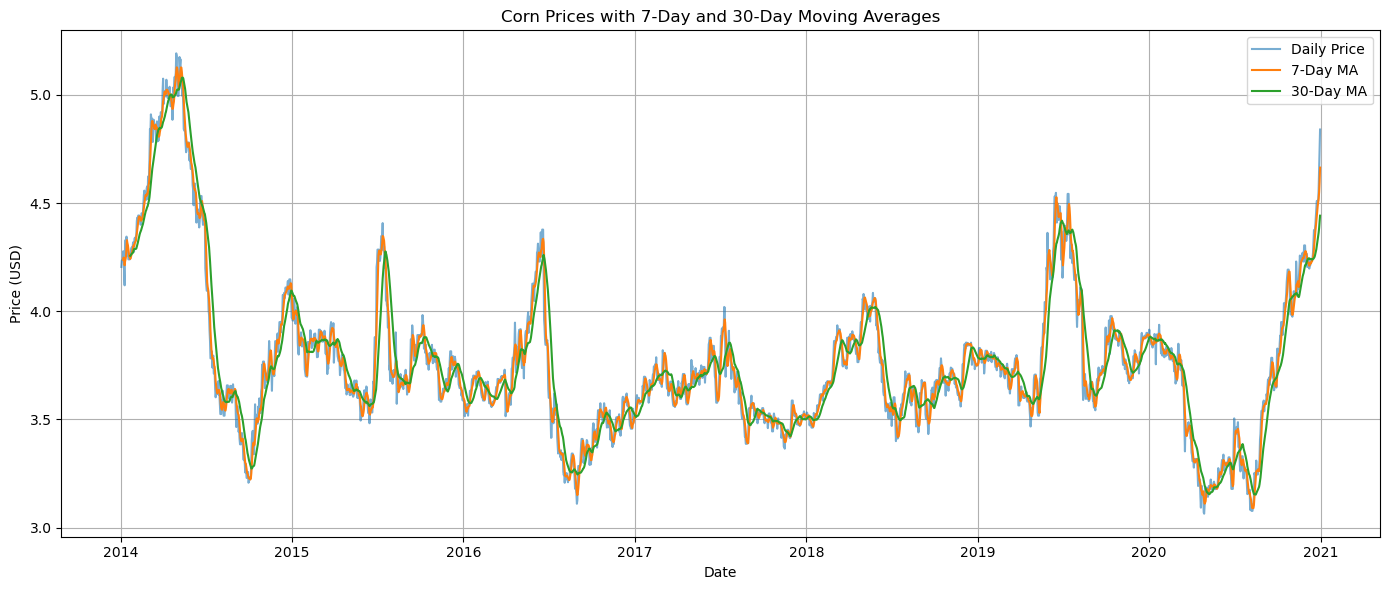

In [4]:
# Calculate moving averages
corn_df["MA_7"] = corn_df["Price"].rolling(window=5).mean()
corn_df["MA_30"] = corn_df["Price"].rolling(window=20).mean()



# Plot the results
plt.figure(figsize=(14, 6))
plt.plot(corn_df["Date"], corn_df["Price"], label="Daily Price", alpha=0.6)
plt.plot(corn_df["Date"], corn_df["MA_7"], label="7-Day MA")
plt.plot(corn_df["Date"], corn_df["MA_30"], label="30-Day MA")
plt.title("Corn Prices with 7-Day and 30-Day Moving Averages")
plt.xlabel("Date")
plt.ylabel("Price (USD)")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


Process the price data to create trading signals e.g. MA5 and MA20 crossovers 

In [ ]:
# Create signal column: 1 = bullish crossover, -1 = bearish crossover, 0 = no crossover
corn_df["Signal"] = 0
corn_df.loc[(corn_df["MA_7"] > corn_df["MA_30"]) & (corn_df["MA_7"].shift(1) <= corn_df["MA_30"].shift(1)), "Signal"] = 1  # Bullish crossover
corn_df.loc[(corn_df["MA_7"] < corn_df["MA_30"]) & (corn_df["MA_7"].shift(1) >= corn_df["MA_30"].shift(1)), "Signal"] = -1 # Bearish crossover

# Filter crossover events
crossover_events = corn_df[corn_df["Signal"] != 0][["Date", "Price", "Signal"]]
print(crossover_events)

# Extract crossover points for plotting
bullish = corn_df[corn_df["Signal"] == 1]
bearish = corn_df[corn_df["Signal"] == -1]
corn_df["Date"] = pd.to_datetime(corn_df["Date"])

# Count occurrences of each label
label_counts = corn_df["Signal"].value_counts(dropna=False)
print(label_counts)


# Save to CSV (optional)
corn_df.to_csv("corn_signal.csv", index=False)
# bullish.to_csv("bullish.csv", index=False)
# bearish.to_csv("bearish.csv", index=False)

           Date   Price  Signal
22   2014-01-24  4.2950       1
78   2014-03-21  4.7900      -1
84   2014-03-27  4.9200       1
105  2014-04-17  4.9475      -1
113  2014-04-25  5.0815       1
...         ...     ...     ...
2464 2020-10-01  3.8275       1
2494 2020-10-31  3.9850      -1
2504 2020-11-10  4.2300       1
2528 2020-12-04  4.2050      -1
2540 2020-12-16  4.2725       1

[153 rows x 3 columns]
Signal
 0    2403
 1      77
-1      76
Name: count, dtype: int64


Plot trading signals

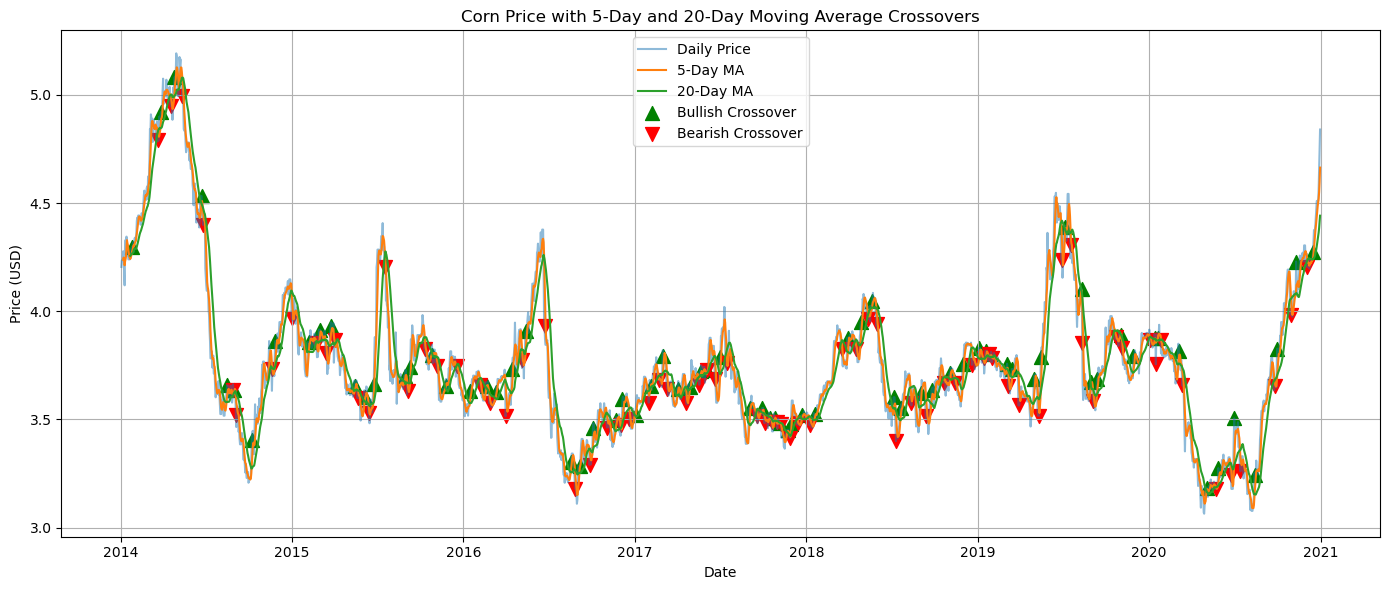

In [ ]:
# Plotting
plt.figure(figsize=(14, 6))
plt.plot(corn_df["Date"], corn_df["Price"], label="Daily Price", alpha=0.5)
plt.plot(corn_df["Date"], corn_df["MA_7"], label="5-Day MA")
plt.plot(corn_df["Date"], corn_df["MA_30"], label="20-Day MA")

# Mark crossovers
plt.scatter(bullish["Date"], bullish["Price"], color="green", marker="^", s=100, label="Bullish Crossover")
plt.scatter(bearish["Date"], bearish["Price"], color="red", marker="v", s=100, label="Bearish Crossover")

# Final setup for plot
plt.title("Corn Price with 5-Day and 20-Day Moving Average Crossovers")
plt.xlabel("Date")
plt.ylabel("Price (USD)")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

Load and process the news data

In [ ]:
# Load the dataset
df_news = pd.read_csv("archive/All_News_Corn_Soybeans.csv")

# Fix the misspelled column name
df_news = df_news.rename(columns={"Healline": "Headline"})

# Convert headline and news text to lowercase for filtering
df_news["Headline_lower"] = df_news["Headline"].str.lower()
df_news["News_lower"] = df_news["News"].str.lower()

# Create boolean filters to identify corn and soybean news
corn_filter = df_news["Headline_lower"].str.contains("corn") | df_news["News_lower"].str.contains("corn")
#soy_filter = corn_df_news["Headline_lower"].str.contains("soy") | corn_df_news["News_lower"].str.contains("soy")

# Create separate DataFrames
df_news = df_news[corn_filter].drop(columns=["Headline_lower", "News_lower"])
df_news.head()
#soy_news_corn_df = corn_df_news[soy_filter].drop(columns=["Headline_lower", "News_lower"])

# (Optional) Save them to CSV
#corn_news_corn_df_news.to_csv("corn_news.csv", index=False)
#soy_news_corn_df_news.to_csv("soy_news.csv", index=False)

df_news = df_news.sort_values("Date", ascending=True).reset_index(drop=True)
df_news.to_csv("cornNews.csv", index=False)


Aggregate multiple news to single cell

In [ ]:
# Stuff needed to aggregate multiple news belonging to single day
# May also be used to create a news memory to make news sticky for n days
# Parameters news memory
n_days = 1

# Ensure Date is datetime
df_news["Date"] = pd.to_datetime(df_news["Date"])
df_news = df_news.sort_values("Date")

# Create full date range from min to max date
date_range = pd.date_range(start=corn_df["Date"].min(), end=corn_df["Date"].max())

# Initialize output list
expanded_rows = []

# Loop through each date in range
for current_date in date_range:
    # Find all news from the previous n days (including today)
    start_date = current_date - timedelta(days=n_days - 1)
    mask = (df_news["Date"] >= start_date) & (df_news["Date"] <= current_date)
    window_news = df_news.loc[mask, "Headline"].dropna()
    
    # Join the news text
    joined_headlines = " ||| ".join(window_news)
    
    # Save the result
    expanded_rows.append({
        "Date": current_date,
        "merged_headlines": joined_headlines
    })

# Create the final DataFrame
news_rolling_df = pd.DataFrame(expanded_rows)
news_rolling_df.to_csv("news_rolling.csv", index=False)


Merge news and price data to single dataframe

In [9]:
# Select only relevant columns from each DataFrame
corn_df1_selected = corn_df[["Date", "Signal"]]

# Perform outer join on the 'Date' column
corn_df_merged_pre = pd.merge(corn_df1_selected, news_rolling_df, on="Date", how="outer")

# Optional: sort by date
corn_df_merged_pre = corn_df_merged_pre.sort_values("Date").reset_index(drop=True)

# Crop first 20 data because MA20 is wrong
corn_df_merged=corn_df_merged_pre[20:]

# # Save to CSV (optional)
corn_df_merged.to_csv("merged_data_news.csv", index=False)


Check the unbalanced nature of the dataset

In [ ]:
# This is stuff needed to visualize the unbalanced dataset
# Count occurrences of each label
label_counts = corn_df_merged["Signal"].value_counts(dropna=False)
print(label_counts)

# Calculate proportions (percentages)
label_distribution = corn_df_merged["Signal"].value_counts(normalize=True) * 100
print(label_distribution)


Signal
 0    2383
 1      77
-1      76
Name: count, dtype: int64
Signal
 0    93.966877
 1     3.036278
-1     2.996845
Name: proportion, dtype: float64


Find the next change in sentiment in a window of n days
After calculation of correct upcoming signals which is important for prediction
Data set is filtered to remove days with no news

In [ ]:
# The function to determine first different signal in future n days
def first_different_or_self(series, n):
    result = []
    signals = series.values
    for i in range(len(signals)):
        current = signals[i]
        found = current  # default to current signal
        for j in range(1, n + 1):
            if i + j < len(signals) and signals[i + j] != current:
                found = signals[i + j]
                break
        result.append(found)
    return result

# Apply to your DataFrame
corn_df_merged["first_diff"] = first_different_or_self(corn_df_merged["Signal"], n=5)

# Drop rows where 'joined_headline' is missing or empty
# Because empty fields are meaningless for training
corn_df_merged_drop = pd.DataFrame(columns=corn_df_merged.columns)
corn_df_merged_drop = corn_df_merged.dropna(subset=["merged_headlines"])
corn_df_merged_drop = corn_df_merged[corn_df_merged["merged_headlines"].str.strip() != ""]

corn_df_merged_drop.to_csv("merged_data_news_processed.csv", index=False)

/var/folders/k2/j4wy4l8s1qlg5cksrxn3bvy80000gn/T/ipykernel_90049/3517614699.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  corn_df_merged["first_diff"] = first_different_or_self(corn_df_merged["Signal"], n=5)


Create train, validation and test sets

In [ ]:
# Set split ratios
train_split_idx = int(len(corn_df_merged_drop) * 0.7)
val_split_idx = int(len(corn_df_merged_drop) * 0.85)

# Create train/validation/test sets
train_df = corn_df_merged_drop.iloc[:train_split_idx].copy()
eval_df = corn_df_merged_drop.iloc[train_split_idx:val_split_idx].copy()
test_df = corn_df_merged_drop.iloc[val_split_idx:].copy()

# Stuff related to debugging
print(f"Train size: {len(train_df)}, Test size: {len(test_df)}")

print(train_df["merged_headlines"].iloc[0])
print(type(train_df["merged_headlines"].iloc[0]))

print(test_df["merged_headlines"].iloc[0])
print(type(test_df["merged_headlines"].iloc[0]))

train_df.to_csv("train_df.csv", index=False)
test_df.to_csv("test_df.csv", index=False)
eval_df.to_csv("eval_df.csv", index=False)


Train size: 909, Test size: 195
Argentine Economy on Accelerated Downward Spiral
<class 'str'>
Brazil Full-Season Corn Impacted by Dry Weather in S. Brazil
<class 'str'>


Processing related to creation of hugging face format datasets

In [ ]:
# Hugging Face expects labels as integers starting from 0
label_map = {-1: 0, 0: 1, 1: 2}
train_df["label"] = train_df["first_diff"].map(label_map)
test_df["label"] = test_df["first_diff"].map(label_map)
eval_df["label"] = eval_df["first_diff"].map(label_map)

# Stuff for debugging
print(train_df.head())
print(test_df.head())
print(eval_df.head())

# Flattens text
def ensure_string(x):
    if isinstance(x, list):
        return " ||| ".join(map(str, x))  # flatten if list
    return str(x)

# Apply text flattening function
train_df["text"] = train_df["merged_headlines"].apply(ensure_string)
test_df["text"] = test_df["merged_headlines"].apply(ensure_string)
eval_df["text"] = eval_df["merged_headlines"].apply(ensure_string)

# Convert to Hugging Face Dataset
train_dataset = Dataset.from_pandas(train_df[["text", "label"]], preserve_index=False)
test_dataset = Dataset.from_pandas(test_df[["text", "label"]], preserve_index=False)
eval_dataset = Dataset.from_pandas(eval_df[["text", "label"]], preserve_index=False)

# Save to csv
train_dataset.to_csv("train_dataset.csv", index=False)
test_dataset.to_csv("test_dataset.csv", index=False)
eval_dataset.to_csv("eval_dataset.csv", index=False)


         Date  Signal                                   merged_headlines  \
26 2014-01-28       0   Argentine Economy on Accelerated Downward Spiral   
28 2014-01-30       0  Brazil Soybeans are 93% GMO, Corn is 82%, and ...   
29 2014-01-31       0  Brazil Soy Farmers Generally Successful Contro...   
33 2014-02-04       0  Cities in Southern Brazil endure Record High J...   
34 2014-02-05       0  Argentine Farmers Hold their Grain amid Econom...   

    first_diff  label  
26           0      1  
28           0      1  
29           0      1  
33           0      1  
34           0      1  
           Date  Signal                                   merged_headlines  \
2203 2020-01-14       0  Brazil Full-Season Corn Impacted by Dry Weathe...   
2204 2020-01-15       1  Corn in Argentina 88% Planted, Northern Argent...   
2205 2020-01-16      -1  Tight Corn Supplies in Southern Brazil could W...   
2206 2020-01-17       0  Brazilian Farmers have Started to Plant their ...   
2210 2020

Creating CSV from Arrow format:   0%|          | 0/1 [00:00<?, ?ba/s]

Creating CSV from Arrow format:   0%|          | 0/1 [00:00<?, ?ba/s]

Creating CSV from Arrow format:   0%|          | 0/1 [00:00<?, ?ba/s]

16696

Here tokenization is executed. 
Several steps were included to observe correct execution of tokenization

In [ ]:
# Define tokenizer function
def tokenize(batch):
    return tokenizer.batch_encode_plus(
        batch["text"],
        truncation=True,
        padding="max_length",    # Force padding to max_length, not dynamic
        max_length=512,
        return_attention_mask=True
    )


# Apply tokenizer function
train_tokenized = train_dataset.map(tokenize, batched=True)
test_tokenized = test_dataset.map(tokenize, batched=True)
eval_tokenized = eval_dataset.map(tokenize, batched=True)

# Stuff related to debugging
print(train_tokenized[0])
print(test_tokenized[0])
print(eval_tokenized[0])

print(type(train_tokenized))

# Here the important thing is:
# Padding and truncation is applied only to input_ids
# Text field stays as is

lengths_train = [len(x) for x in train_tokenized["input_ids"]]
print(set(lengths_train))  # Should print: {512}

lengths_test = [len(x) for x in test_tokenized["input_ids"]]
print(set(lengths_test))  # Should print: {512}

lengths_eval = [len(x) for x in eval_tokenized["input_ids"]]
print(set(lengths_eval))  # Should print: {512}



This step is very important because when text field is fed to the dataloader when creating batches it returns error. So text field must be removed.
The trainer works based on input ids created during tokenization
So text field is not necessary

In [ ]:
# Remove unnecessary columns because dataloader returns error
train_tokenized_rm = train_tokenized.remove_columns(["text"])
test_tokenized_rm = test_tokenized.remove_columns(["text"])
eval_tokenized_rm = eval_tokenized.remove_columns(["text"])



This is class definitions related to custom loss function usage with trainer

In [16]:
# Class and function definitions related to custom loss function

class CustomLossTrainer(Trainer):
    def __init__(self, *args, loss_fn=None, **kwargs):
        super().__init__(*args, **kwargs)
        # Store your custom loss function.
        # This should take (logits, labels) as arguments.
        self.loss_fn = loss_fn

    def compute_loss(self, model, inputs, return_outputs=False, **kwargs):
        # Assume your inputs include "labels" and your model returns logits.
        labels = inputs.get("labels")
        outputs = model(**inputs)
        logits = outputs.get("logits")
        
        # Compute the custom loss using your loss function.
        loss = self.loss_fn(logits, labels)
        
        return (loss, outputs) if return_outputs else loss





Parameters needed for balancing the data set are used to calculate the custom loss function

In [ ]:
# Stuff necessary for balancing the dataset with custom weight function
classes=np.unique(train_df["label"])
y_train=train_df["label"].values
class_weights = compute_class_weight(class_weight="balanced", classes=classes, y=y_train)
weights_tensor = torch.tensor(class_weights, dtype=torch.float)

# Again select mps for apple silicon
device = torch.device("mps" if torch.backends.mps.is_available() else "cpu")
model.to(device)

# This is removed outside the function to speed up 
# execution of focal_loss function
weights_tensor=weights_tensor.to(device)

def focal_loss(logits, labels, gamma=2.0, alpha=0.25, class_weights=None):
    
    """
    logits: raw model outputs (before softmax)
    labels: true class labels
    gamma: focusing parameter for focal loss
    alpha: scalar to balance easy vs hard examples (optional if using class_weights)
    class_weights: torch tensor of shape [num_classes], optional
    """

    # Calculate standard cross-entropy loss first.
    ce_loss = F.cross_entropy(logits, labels, reduction='none')
    
    # Get softmax probabilities.
    pt = torch.exp(-ce_loss)
    
    # Step 3: Apply focal loss scaling
    focal_term = (1 - pt) ** gamma

    # Step 4: Get per-sample weights from class_weights
    if class_weights is not None:
        weights = class_weights[labels]  # pick weight for each sample's true class
    elif alpha is not None:
        weights = alpha
    else:
        weights = 1.0

    # Step 5: Apply weights and return mean
    loss = weights * focal_term * ce_loss
    return loss.mean()


    # # Compute focal loss.
    # focal_loss = alpha * (1 - pt) ** gamma * ce_loss
    # return focal_loss.mean()


# Create weighted focal loss instance
def weighted_focal_loss(logits, labels):
    return focal_loss(logits, labels, gamma=2.0, class_weights=weights_tensor)



Trainer is executed here

In [ ]:
# Facilitation of Trainer

training_args = TrainingArguments(
    output_dir="./finbert-corn-model",
    evaluation_strategy="epoch",
    save_strategy="epoch",
    num_train_epochs=4,
    per_device_train_batch_size=8,
    per_device_eval_batch_size=8,
    logging_steps=50,
    save_steps=500,
    learning_rate=2e-5,
    logging_dir='./logs',
)



trainer = CustomLossTrainer(
    model=model,
    args=training_args,
    train_dataset=train_tokenized_rm,
    eval_dataset=eval_tokenized_rm,
    tokenizer=tokenizer,
    # data_collator=data_collator,              # ✅ REQUIRED
    loss_fn=weighted_focal_loss
)



# trainer = Trainer(
#     model=model,
#     args=training_args,
#     train_dataset=train_tokenized_rm,
#     eval_dataset=eval_tokenized_rm,
#     tokenizer=tokenizer,
#     data_collator=data_collator, 
#     compute_loss_func=compute_weighted_loss
# )

trainer.train()


Evaluate and save the model

In [ ]:
# Evaluate
trainer.evaluate()

# Save
trainer.save_model("./finbert-corn-model")
tokenizer.save_pretrained("./finbert-corn-model")


When using previously trained model, this is used to laod the model

In [19]:
# Necessary to load pre-trained model
model_path = "./finbert-corn-model"  # or full path to saved model dir

tokenizer = AutoTokenizer.from_pretrained(model_path)
model = AutoModelForSequenceClassification.from_pretrained(model_path)


Dataloader is setup to make predictions on test set

In [ ]:
# Stuff necessary for making predictions on test set. 
data_collator = DataCollatorWithPadding(tokenizer=tokenizer)
test_loader = DataLoader(test_tokenized_rm, batch_size=8, collate_fn=data_collator)

model.eval()
device = torch.device("mps" if torch.backends.mps.is_available() else "cpu")
model.to(device)

all_preds = []
all_labels = []

# stuff used during debugging
batch = next(iter(test_loader))
print(batch.keys())  # e.g., dict_keys(['input_ids', 'attention_mask', 'labels'])
print(batch["input_ids"].shape)       # torch.Size([4, 512])
print(batch["attention_mask"].shape)  # torch.Size([4, 512])
print(batch["labels"])                # tensor of shape [4]

# Execute dataloader for predictions on test set
with torch.no_grad():
    for batch in test_loader:
        input_ids = batch["input_ids"].to(device)
        attention_mask = batch["attention_mask"].to(device)
        labels = batch["labels"].to(device)

        outputs = model(input_ids=input_ids, attention_mask=attention_mask)
        preds = torch.argmax(outputs.logits, dim=1)

        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())


dict_keys(['input_ids', 'token_type_ids', 'attention_mask', 'labels'])
torch.Size([8, 512])
torch.Size([8, 512])
tensor([2, 0, 1, 2, 1, 1, 1, 1])


Here performance evaluation is conducted

In [21]:
# Convert predictions back to original labels
reverse_label_map = {0: -1, 1: 0, 2: 1}
all_preds_mapped = [reverse_label_map[p] for p in all_preds]
all_labels_mapped = [reverse_label_map[l] for l in all_labels]

# Setup Evaluation Metrics
print("Accuracy:", accuracy_score(all_labels_mapped, all_preds_mapped))
print("\nClassification Report:")
print(classification_report(all_labels_mapped, all_preds_mapped, digits=3))
print("\nConfusion Matrix:")
print(confusion_matrix(all_labels_mapped, all_preds_mapped))


Accuracy: 0.5743589743589743

Classification Report:
              precision    recall  f1-score   support

          -1      0.094     0.143     0.113        21
           0      0.817     0.686     0.746       156
           1      0.062     0.111     0.080        18

    accuracy                          0.574       195
   macro avg      0.324     0.313     0.313       195
weighted avg      0.669     0.574     0.616       195


Confusion Matrix:
[[  3  12   6]
 [ 25 107  24]
 [  4  12   2]]


The prediction data is aggregated to create a single file to visually observe the final output

In [22]:
# Observe test set predictions
predictions=pd.DataFrame({
    "text": test_df["text"],  # or "merged_news", depending on your field
    "true_label": all_labels_mapped,
    "predicted_label": all_preds_mapped
})

predictions.to_csv("predictions.csv", index=False)